In [117]:
import pandas as pd
import numpy as np
import os
from dateutil.parser import parse
from pandas.tseries.offsets import BDay
import pickle
import fnmatch
from tqdm import tqdm, tqdm_notebook
import datetime as dt
from datetime import timedelta
import glob
import seaborn as sns
#Set PANDAS to show all columns in DataFrame
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
def listdirs(folder): #return only directories from a master folder
    return [d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))]

def find_path(basepath, stringname):
    for fname in os.listdir(basepath):
        path = os.path.join(basepath, fname)
        if os.path.isdir(path):
            if stringname in fname:
                return path
def get_ticket(rx_path):
    ticker=rx_path.split(".")[0].split("/")[-1].split("-")[0]
    return ticker

def ticker_trades_dir(ticker):
    dest=os.path.join(os.getenv('FINANCE_DATA'), "_".join((ticker,'trades')))
    if not os.path.isdir(dest):
        os.makedirs(dest)
def quotes_trades_dir(ticker):
    dest=os.path.join(os.getenv('FINANCE_DATA'), "_".join((ticker,'quotes')))
    if not os.path.isdir(dest):
        os.makedirs(dest)
def agg_on_trd_time(gr):
    """
    Utility func to aggregate trades on timestamp. All trades with equal time stamp
    will collapse to one row and the traded price will be the volume weighted traded
    price.
    """
    vTrdPrice = np.sum(gr['TradedPrice'] * gr['Volume'])/np.sum(gr['Volume'])
    volume = np.sum(gr['Volume'])

    return pd.Series({'Volume': volume,
                      'TradedPrice': vTrdPrice})

def open_pickle_file(path, pickle_file):
    file_loc = os.path.join(path, pickle_file)
    pickle_to_file = pickle.load(open(file_loc, "rb"))
    return pickle_to_file
def common_member(a, b): 
      
    a_set = set(a) 
    b_set = set(b) 
      
    # check length  
    if len(a_set.intersection(b_set)) > 0: 
        return(a_set.intersection(b_set))   
    else: 
        return("no common elements") 

def f(x):
     return Series(dict(Number_of_tweets = x['content'].count(), 
                        Company=x['Company'].min(),
                        Description=x['from_user_description'].min(),
                        ))
    
def obv_calc(df):
    df['SignedVolume']=df['Volume']*np.sign(df['TradedPrice'].diff()).cumsum()
    df['SignedVolume'][:1]=0
    df['OBV']=df['SignedVolume'].cumsum()
    df =df.drop(columns=['SignedVolume'])
    return df
def chaikin_mf(df, period=5):
    df["MF Multiplier"] = (df['TradedPrice']-(df['TradedPrice'].expanding(period).min() ) \
                           - (df['TradedPrice'].expanding(period).max() - df['TradedPrice']))/(df['TradedPrice'].expanding(period).max() - df['TradedPrice'].expanding(period).min())
    df["MF Volume"] = df['MF Multiplier'] * df['Volume'] 
    df['CMF']= df['MF Volume'].sum()/df["Volume"].rolling(5).sum()
    df=df.drop(columns=['MF Multiplier','MF Volume'])
    return df

## Tick bars

In [111]:
def tick_bars(df, price_column, m):
    '''
    compute tick bars

    # args
        df: pd.DataFrame()
        column: name for price data
        m: int(), threshold value for ticks
    # returns
        idx: list of indices
    '''
    t = df[price_column]
    ts = 0
    idx = []
    for i, x in enumerate(tqdm(t)):
        ts += 1
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx

def tick_bar_df(df, price_column, m):
    idx = tick_bars(df, price_column, m)
    return df.iloc[idx].drop_duplicates()

def plot_sample_data(ref, sub, bar_type, *args, **kwds):
    f,axes=plt.subplots(3,sharex=True, sharey=True, figsize=(10,7))
    ref.plot(*args, **kwds, ax=axes[0], label='price')
    sub.plot(*args, **kwds, ax=axes[0], marker='X', ls='', label=bar_type)
    axes[0].legend();
    
    ref.plot(*args, **kwds, ax=axes[1], label='price', marker='o')
    sub.plot(*args, **kwds, ax=axes[2], ls='', marker='X',
             color='r', label=bar_type)

    for ax in axes[1:]: ax.legend()
    plt.tight_layout()
    
    return

def select_sample_data(ref, sub, price_col, date):
    '''
    select a sample of data based on date, assumes datetimeindex
    
    # args
        ref: pd.DataFrame containing all ticks
        sub: subordinated pd.DataFrame of prices
        price_col: str(), price column
        date: str(), date to select
    # returns
        xdf: ref pd.Series
        xtdf: subordinated pd.Series
    '''
    xdf = ref[price_col].loc[date]
    xtdf = sub[price_col].loc[date]
    return xdf, xtdf

In [45]:
# Author:  Raghav RV <rvraghav93@gmail.com>
#          Guillaume Lemaitre <g.lemaitre58@gmail.com>
#          Thomas Unterthiner
# License: BSD 3 clause

import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn.datasets import fetch_california_housing

print(__doc__)



# Take only 2 features to make visualization easier
# Feature of 0 has a long tail distribution.
# Feature 5 has a few but very large outliers.


def distributions(X):
        
    distributions = [
        ('Unscaled data', X),
        ('Data after standard scaling',
            StandardScaler().fit_transform(X)),
        ('Data after min-max scaling',
            MinMaxScaler().fit_transform(X)),
        ('Data after max-abs scaling',
            MaxAbsScaler().fit_transform(X)),
        ('Data after robust scaling',
            RobustScaler(quantile_range=(25, 75)).fit_transform(X)),
        ('Data after power transformation (Yeo-Johnson)',
         PowerTransformer(method='yeo-johnson').fit_transform(X)),
#         ('Data after power transformation (Box-Cox)',
#          PowerTransformer(method='box-cox').fit_transform(X)),
#         ('Data after quantile transformation (gaussian pdf)',
#             QuantileTransformer(output_distribution='normal')
#             .fit_transform(X)),
        ('Data after quantile transformation (uniform pdf)',
            QuantileTransformer(output_distribution='uniform')
            .fit_transform(X)),
        ('Data after sample-wise L2 normalizing',
            Normalizer().fit_transform(X)),
    ]
    return distributions



 Exterrnal Files


In [85]:
def generate_sample_from_biv_gaussian_copula(rho, size):
    """
    Returns a sample from a bivariate Gaussian copula of correlation rho.

    :param rho: the correlation parameter
    :param size: the size of the sample

    :return: a (size, 2) numpy array of samples
    """
    mv_normal = np.random.multivariate_normal([0,0], [[1,rho],[rho,1]], size)
    samples = norm.cdf(mv_normal)
    return samples

## Volume Bars

In [113]:
def volume_bars(df, volume_column, m):
    '''
    compute volume bars

    # args
        df: pd.DataFrame()
        volume_column: name for volume data
        m: int(), threshold value for volume
    # returns
        idx: list of indices
    '''
    t = df[volume_column]
    ts = 0
    idx = []
    for i, x in enumerate(tqdm(t)):
        ts += x
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx

def volume_bar_df(df, volume_column, m):
    idx = volume_bars(df, volume_column, m)
    return df.iloc[idx].drop_duplicates()

In [4]:
def plot(data):
    plt.figure(figsize=(16,4))

    plt.subplot(1, 2, 1)
    plt.scatter(data["x"], data["y"])
    plt.xlabel("x")
    plt.ylabel("y")

    plt.subplot(1, 2, 2)
    plt.scatter(data["x"], data["z"])
    plt.xlabel("x")
    plt.ylabel("y")

    plt.show()
def transform_to_uniform(x):
    tmp = x.argsort()
    cdf = np.zeros(tmp.shape)
    cdf[tmp] = np.arange(len(x))
    return cdf / len(x)

In [5]:
size = 2000

def generate_plots(data):
    plt.figure(figsize=(20,4))

    plt.subplot(1, 4, 1)
    plt.hist2d(data[:,0], data[:,1], density=True, vmin=0, vmax=1)
    c = plt.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
    plt.colorbar(c)
    plt.title("Real")

    plt.subplot(1, 4, 2)
    try:
        copula = Clayton()
        copula.fit(data)
        synthetic = copula.sample(len(data))
        plt.hist2d(synthetic[:,0], synthetic[:,1], density=True, vmin=0, vmax=1)
        plt.colorbar();
        plt.title("Clayton")
    except:
        print("Skipping Clayton...")

    plt.subplot(1, 4, 3)
    try:
        copula = Gumbel()
        copula.fit(data)
        synthetic = copula.sample(len(data))
        plt.hist2d(synthetic[:,0], synthetic[:,1], density=True, vmin=0, vmax=1)
        plt.colorbar();
        plt.title("Gumbel")
    except:
        print("Skipping Gumbel...")


    plt.subplot(1, 4, 4)
    try:
        copula = Frank()
        copula.fit(data)
        synthetic = copula.sample(len(data))
        plt.hist2d(synthetic[:,0], synthetic[:,1], density=True, vmin=0, vmax=1)
        plt.colorbar();
        plt.title("Frank")
    except:
        print("Skipping Frank...")

    plt.show()

In [6]:
##locations ##
dataOnlyDrive = ('/media/ak/WorkDrive/Data')
''' Exterrnal Files'''
extPath = '/media/ak/My Passport/Experiment Data'
barketData = '/media/ak/My Passport/Barket Data/'

In [7]:
targetDrive = barketData
bmrg_folders=[s for s in os.listdir(targetDrive ) if s.endswith('Comdty')]
bmrg_trades=sorted([s for s in os.listdir(targetDrive ) if s.endswith('y_trades')])
bmrg_quotes=sorted([s for s in os.listdir(targetDrive ) if s.endswith('y_quotes')])
bmrg_tickers=sorted([bmrg_trades[idx].split('_t')[0] for idx,_ in enumerate(bmrg_trades)])

In [8]:
# symbols = ['FB1', 'TU1', 'TY1', 'FV1']
print(bmrg_quotes, bmrg_trades)

['TY1_Comdty_quotes', 'US1_Comdty_quotes'] ['TY1_Comdty_trades', 'US1_Comdty_trades']


In [9]:
bmrg_tickers

['TY1_Comdty', 'US1_Comdty']

In [10]:
symbolIdx= 0
# get dates and files
symbol_quotes = os.path.join(targetDrive,str(bmrg_quotes[symbolIdx]))
symbol_trades = os.path.join(targetDrive,str(bmrg_trades[symbolIdx]))
symbolQuoteDates = [quoteFile.split(".")[0] for quoteFile in os.listdir(symbol_quotes)] 
symbolTradeDates = [tradeFile.split(".")[0] for tradeFile in os.listdir(symbol_trades)] 

In [11]:
# TradeQuoteDates =[set(ymQuoteDates).intersection(set(ymTradeDates))]
symbol_quotes


'/media/ak/My Passport/Barket Data/TY1_Comdty_quotes'

In [15]:
# tradeTestDate = os.path.join(symbol_trades, quoteTradeDates[0]+'.csv')
# tradeQuoteDate = os.path.join(symbol_quotes, quoteTradeDates[0]+'.csv')
# trades =pd.read_csv(tradeTestDate,low_memory=False)
# quotes = pd.read_csv(tradeQuoteDate, low_memory=False)

In [16]:
# #create dictionaries that have all the data we may need/want. on for top of the LOB and one for trades
# quoteTradeDates=[eventDate for eventDate in symbolQuoteDates if eventDate in symbolTradeDates]
# len(quoteTradeDates)
# dfAllTrades ={}
# dfAllQuotes ={}
# for idx,date in enumerate(quoteTradeDates):
#     tradeTestDate = pd.read_csv(os.path.join(symbol_trades, quoteTradeDates[idx]+'.csv'))
#     tradeQuoteDate = pd.read_csv(os.path.join(symbol_quotes, quoteTradeDates[idx]+'.csv'))
#     dfAllTrades[date] = tradeTestDate
#     dfAllQuotes[date] = tradeQuoteDate
    
    

In [12]:
dfAllQuotesName = "".join(('AllQuotes',bmrg_quotes[symbolIdx],'Comdty.pkl'))
dfAllTradesName = "".join(('AllTrades',bmrg_trades[symbolIdx],'Comdty.pkl'))

In [13]:
os.path.isfile("/".join((symbol_quotes, dfAllQuotesName)))
allQuotesDict =open_pickle_file(symbol_quotes, dfAllQuotesName)

In [14]:
allTradesDict = open_pickle_file(symbol_trades, dfAllTradesName)

pkl.dump(dfAllQuotes, open("/".join((symbol_quotes, dfAllQuotesName)), "wb"))


pkl.dump(dfAllTrades, open("/".join((symbol_trades, dfAllTradesName)), "wb"))

In [16]:
dQuoteKeys = list(allQuotesDict.keys()) #one common set of keys at the moment
dTradeKeys = list(allTradesDict.keys())
commonDates =list(set(dQuoteKeys).intersection(set(dTradeKeys)))


In [ ]:
#allQuotesDict[dQuoteKeys[1]]

In [17]:
# 
# dfLOBRaw={}
# QuoteColumns =['Unnamed: 0','TimeStamp']
# TradeColumns= ['Unnamed: 0', 'size', 'time', 'type', 'value']
dKeys= commonDates
for idx, dateKey in enumerate(commonDates):
    #dfAllQuotes[dKeys[idx]].reset_index(level=0, inplace=True)
    allQuotesDict[dKeys[idx]]['TimeStamp']= pd.to_datetime(allQuotesDict[dKeys[idx]]['time'])
    allTradesDict[dKeys[idx]]['TradeTimeStamp']= pd.to_datetime(allTradesDict[dKeys[idx]]['time'])
    allTradesDict[dKeys[idx]]['TradedPrice']= allTradesDict[dKeys[idx]]['value']
    allTradesDict[dKeys[idx]]['TradedSize']= allTradesDict[dKeys[idx]]['size']
    allTradesDict[dKeys[idx]].rename(columns = {'type':'QuotedSide','value':'bestPrice','size':'QuoteSize','time':'QuoteTimeStamp'}, inplace = True) 
    allTradesDict[dKeys[idx]]['Duration']=allTradesDict[dKeys[idx]].TradeTimeStamp.diff()/np.timedelta64(1, 'ms')
    
    

In [19]:
commonKeys =list(set(allTradesDict).intersection(set(allQuotesDict)))

In [20]:
idxKey=1
dfBID=allQuotesDict[commonKeys[idxKey]][allQuotesDict[commonKeys[idxKey]]['type']=='BID'].rename(columns={'type':'BidSide','value':'bestBidPrice','size':'bestBidSize','time':'TimeStampS'})
dfASK=allQuotesDict[commonKeys[idxKey]][allQuotesDict[commonKeys[idxKey]]['type']=='ASK'].rename(columns={'type':'BidSide','value':'bestBidPrice','size':'bestBidSize','time':'TimeStampS'})
#  =dfAllQuotes[commonDates[idx]][dfAllQuotes[commonDates[idx]]['type']=='BID'].rename(columns={'type':'BidSide','value':'bestBidPrice','size':'bestBidSize','time':'TimeStampS'})#.drop(QuoteColumns, inplace=True, axis=1)
# dfASK =dfAllQuotes[commonDates[idx]][dfAllQuotes[commonDates[idx]]['type']=='ASK'].rename(columns={'type':'AskSide','value':'bestAskPrice','size':'bestAskSize','time':'TimeStampS'})#.drop(QuoteColumns, inplace=True, axis=1)

In [44]:
allTradesDict[commonDates[idx]] = allTradesDict[commonDates[idxKey]].rename(index=str, columns={"QuoteSize": "TradedVolume","TradeTimeStamp":"TimeStampS"})#.drop(columns=['Unnamed: 0'])

In [23]:
dfClean = allTradesDict[commonDates[idx]].rename(index=str)

In [24]:
# dfMergedLOB = dfBID.merge(dfASK,left_on='TimeStampS', right_on='TimeStampS')

In [31]:
dfClean.head(4)

,Unnamed: 0,QuoteSize,QuoteTimeStamp,QuotedSide,bestPrice,TradeTimeStamp,TradedPrice,TradedSize,Duration
0,48,2,2018-05-09 00:00:39,TRADE,119.46875,2018-05-09 00:00:39,119.46875,2,NaN
1,116,3,2018-05-09 00:01:23,TRADE,119.46875,2018-05-09 00:01:23,119.46875,3,44000.0
2,131,1,2018-05-09 00:01:57,TRADE,119.46875,2018-05-09 00:01:57,119.46875,1,34000.0
3,135,1,2018-05-09 00:01:57,TRADE,119.46875,2018-05-09 00:01:57,119.46875,1,0.0


In [88]:
dfClean = dfClean.dropna()
x= dfClean.TradedPrice.pct_change().dropna()
y= dfClean.Duration
z= dfClean.TradedSize
z_min = np.min(z)
z_max= np.max(z)

In [97]:
len(y) == len(z)

True

In [33]:

rng = np.random.RandomState(304)
bc = PowerTransformer(method='box-cox')
yj = PowerTransformer(method='yeo-johnson')
yj = PowerTransformer(method='yeo-johnson')
# n_quantiles is set to the training set size rather than the default value
# to avoid a warning being raised by this example
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal',
                         random_state=rng)

In [90]:
from scipy.stats import rankdata, norm

In [91]:
from sklearn.preprocessing import quantile_transform

In [98]:
# build the empirical copula
rk1 = rankdata(y,method='ordinal')
rk2 = rankdata(z,method='ordinal')
nb_bins = 25
histo2d, xedges, yedges = np.histogram2d(rk1,rk2,bins=nb_bins)
freq_histo2d = histo2d / len(rk1)

In [99]:
# build the independence copula
unif = np.ones((nb_bins,nb_bins)) / len(rk1)

# build the Gaussian copula of correlation rho(X,Y)
rho = np.corrcoef(y,z)[0,1]
samples = generate_sample_from_biv_gaussian_copula(rho, len(rk1))
gcop_hist2d, xedges, yedges = np.histogram2d(samples[:,0], samples[:,1], bins=nb_bins)
freq_gcop2d = gcop_hist2d / len(rk1)


min_cops = min(freq_histo2d.min(), unif.min(), freq_gcop2d.min())
max_cops = max(freq_histo2d.max(), unif.max(), freq_gcop2d.max())

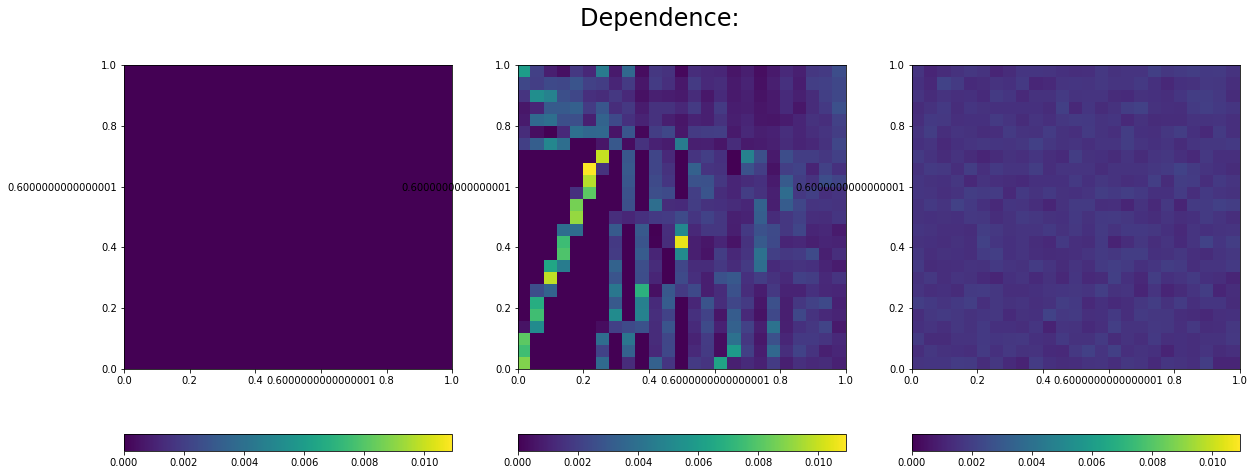

In [102]:
# display the distributions
plt.figure(figsize=(20,8))

plt.suptitle('Dependence: ',fontsize=24)

ax = plt.subplot(1,3,1)
cax = ax.pcolormesh(unif, vmin=min_cops, vmax=max_cops)
cbar = plt.colorbar(cax,orientation='horizontal')
ax.xaxis.set_ticklabels(np.linspace(0,1,6))
ax.yaxis.set_ticklabels(np.linspace(0,1,6))

ax = plt.subplot(1,3,2)
cax = ax.pcolormesh(freq_histo2d, vmin=min_cops, vmax=max_cops)
cbar = plt.colorbar(cax,orientation='horizontal')
ax.xaxis.set_ticklabels(np.linspace(0,1,6))
ax.yaxis.set_ticklabels(np.linspace(0,1,6))

ax = plt.subplot(1,3,3)
cax = ax.pcolormesh(freq_gcop2d, vmin=min_cops, vmax=max_cops)
cbar = plt.colorbar(cax,orientation='horizontal')
ax.xaxis.set_ticklabels(np.linspace(0,1,6))
ax.yaxis.set_ticklabels(np.linspace(0,1,6))

plt.show()

In [122]:
import pprint
volume_M =  14 # arbitrary 
print(f'volume threshold: {volume_M:,}')
v_bar_df = volume_bar_df(dfClean, 'TradedSize', volume_M)


100%|██████████| 36799/36799 [00:00<00:00, 2589788.13it/s]

volume threshold: 14


In [143]:
test = v_bar_df.TradedPrice.pct_change().dropna().values
test.shape

(14636,)

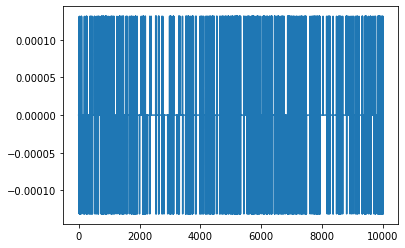

In [141]:
plt.plot(test[0:10000])

In [144]:
from numpy import cumsum, polyfit, polyval, mean, sqrt

In [145]:
RW1=cumsum(test-mean(test));
RW2=cumsum(test-mean(test));
RW3=cumsum(test-mean(test));

Text(0, 0.5, 'Multifractal signal\namplitude')

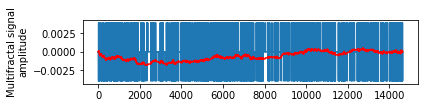

In [147]:

A = 30.0
plt.subplot(311)
plt.plot(A*test)
plt.plot(RW3,'r',lw=1.5)
plt.ylabel('Multifractal signal\namplitude',ha='center')

Text(0, 0.5, 'White noise\namplitude')

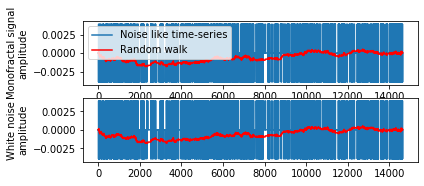

In [148]:
plt.subplot(312)
plt.plot(A*test)
plt.plot(RW2,'r',lw=1.5)
plt.legend(['Noise like time-series','Random walk'])
plt.ylabel('Monofractal signal\namplitude',ha='center')
plt.subplot(313)
plt.plot(A*test)
plt.plot(RW1,'r',lw=1.5)
plt.ylabel('White noise\namplitude',ha='center')
# if SAVE: savefig('figure1.png')

In [151]:
def plot_rms(x,label=''):
    RMS = sqrt((x**2).sum())
    plot(x)
    x0 = x.mean()
    x1 = x.std()
    plot(xlim(),x0*r_[1,1],'r--')
    plot(xlim(),(x0+x1)*r_[1,1],'r-',lw=1.25)
    plot(xlim(),(x0-x1)*r_[1,1],'r-',lw=1.25)
    ylabel(label,ha='center')

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

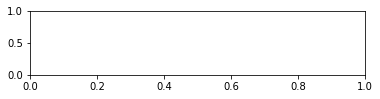

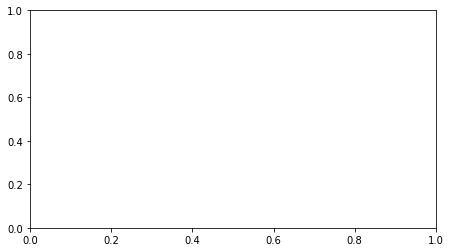

In [152]:
plt.subplot(311)
plot_rms(test,'Multifractal signal\namplitude')
plt.legend(['Noise like time-series','Mean','+/- 1 RMS'])

In [163]:
fig, ax = plt.subplots()
fig = plt.figure(1, figsize=(8, 14), frameon=False, dpi=100)
fig.add_axes([0, 0, 1, 1])
ax = plt.gca()


def plot_trends(X,scale,m=1,label='',title=''):
    t = np.arange(X.shape[0])
    plt.plot(t,X)
    for i0 in range(0,X.shape[0]-scale+1,scale):
        i1 = i0+scale
        t0 = t[i0:i1]
        C = polyfit(t0,X[i0:i1],m)
        fit = polyval(C,t0);
        RMS = sqrt(((X[i0:i1]-fit)**2).mean())
        plt.plot(t0,fit,'r--')
        plt.plot(t0,fit-RMS,'r')
        plt.plot(t0,fit+RMS,'r')
    plt.ylabel(label,ha='center')
    if title: plt.text(100,500,title,fontsize=12) 

scale = 1000
RW = cumsum(test-test.mean())

plt.subplot(311)
plot_trends(RW,scale,1,label='Multifractal signal\namplitude',
            title='A Linear detrending')
plt.legend(['Noise like time-series','Local trend','+/- 1 local RMS'])
plt.subplot(312)
plot_trends(RW,scale,2,label='Monofractal signal\namplitude',
            title='B Quadratic detrending')
plt.subplot(313)
plot_trends(RW,scale,3,label='White noise\namplitude',
            title='C Cubic detrending')

# if SAVE: savefig('figure3.png')

ValueError: Image size of 418x12118148 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 3 Axes>

In [164]:
plot_trends(RW,scale,1,label='Multifractal signal\namplitude',
            title='A Linear detrending')

ValueError: Image size of 424x40846650 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 1 Axes>

NameError: name 'step' is not defined

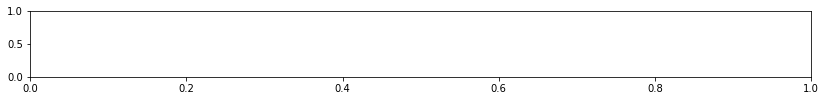

In [167]:
def trends(X,scale,m=1):
    t = np.arange(X.shape[0])
    segments = np.arange(0,X.shape[0]-scale+1,scale)
    RMS = []
    for i0 in segments:
        i1 = i0+scale
        t0 = t[i0:i1]
        C = polyfit(t0,X[i0:i1],m)
        fit = polyval(C,t0)
        RMS.append( sqrt(((X[i0:i1]-fit)**2).mean()) )
    return np.array(RMS)

RW = cumsum(test-test.mean())
scales = 2**np.arange(4,11)
#[16,32,64,128,256,512,1024];
m = 1

plt.figure(figsize=(14,10))
RMS = {}
for si, scale in enumerate(scales):
    plt.subplot(len(scales),1,len(scales)-si)
    t = np.arange(0,RW.shape[0]+1,scale)
    RMS[scale] = trends(RW,scale,m)
    step(t,r_[RMS[scale],RMS[scale][-1]],where='post')
    plt.plot(xlim(),r_[1,1]*RMS[scale].mean(),'r',lw=2.0)
    text(8100,RMS[scale].mean(),'Scale = %d'%scale)
    if scale < 128:
        yticks([0,5,10,20])
    else:
        yticks([0,10,20,40])

plt.xlabel('Sample index')
plt.subplot(len(scales),1,len(scales)//2+1)
plt.ylabel('Amplitude')